
# NYC Food Access — Neighborhood-Level (NTA2020) Analysis

This notebook focuses on a **single standardized neighborhood unit**: NYC Neighborhood
Tabulation Areas (NTA2020). We assume the **metrics CSV (with `nta2020` codes)** is the
source of truth for:
- Which neighborhoods exist
- Their IDs
- Metrics like supply gap, food insecurity, unemployment, etc.

We'll:
1. Load census tracts and dissolve them to NTA polygons.
2. Load the metrics CSV and join it to those polygons.
3. Spatially assign pantry points to NTAs and count pantries per NTA.
4. Compute distance from each NTA centroid to its nearest pantry.
5. Export clean, NTA-level outputs for optimization.


In [9]:

import pandas as pd
import geopandas as gpd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)

# --- EDIT THESE PATHS ---
CENSUS_TRACTS_PATH = "raw/census_tracts.geojson"   # or shapefile, gpkg, etc.
PANTRIES_PATH      = "data/geo/pantries.geojson"    # or CSV with lat/lon
METRICS_CSV        = "raw/Emergency_Food_Supply_Gap_20251110.csv"

# If PANTRIES_PATH is CSV, specify columns:
PANTRY_LAT_COL = "latitude"
PANTRY_LON_COL = "longitude"

CRS_LATLON    = "EPSG:4326"
CRS_PROJECTED = "EPSG:6539"  # NYC-appropriate projected CRS


In [10]:

# ---- Load census tracts ----
tracts_path = Path(CENSUS_TRACTS_PATH)
assert tracts_path.exists(), f"Census tracts file not found: {tracts_path}"

tracts = gpd.read_file(tracts_path)
if tracts.crs is None:
    print("⚠️ Tracts have no CRS; assuming WGS84")
    tracts = tracts.set_crs(CRS_LATLON)

tracts_ll = tracts.to_crs(CRS_LATLON)
tracts_ll.head(2)


,:id,:version,:created_at,:updated_at,ctlabel,borocode,boroname,ct2020,boroct2020,cdeligibil,ntaname,nta2020,cdta2020,cdtaname,geoid,shape_leng,shape_area,geometry
0,row-n3v9_fibw~s7xp,rv-wmam~mr9u-utmz,2025-08-21 13:56:10.254000+00:00,2025-08-21 13:56:10.254000+00:00,1,1,Manhattan,000100,1000100,I,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,10833.0439286,1843004.52241,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,row-r3ub~566h_ntm6,rv-u9kx_vkcu~bxxk,2025-08-21 13:56:10.254000+00:00,2025-08-21 13:56:10.254000+00:00,14.01,1,Manhattan,001401,1001401,I,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.33199951,1006116.58954,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ..."


In [11]:

# ---- Load pantry locations ----
pantry_path = Path(PANTRIES_PATH)
assert pantry_path.exists(), f"Pantry file not found: {pantry_path}"

if pantry_path.suffix.lower() == ".csv":
    pan_df = pd.read_csv(pantry_path)
    for col in [PANTRY_LAT_COL, PANTRY_LON_COL]:
        assert col in pan_df.columns, f"Missing column in pantry CSV: {col}"
    pan_df = pan_df.dropna(subset=[PANTRY_LAT_COL, PANTRY_LON_COL])
    geometry = gpd.points_from_xy(pan_df[PANTRY_LON_COL], pan_df[PANTRY_LAT_COL], crs=CRS_LATLON)
    pantries = gpd.GeoDataFrame(pan_df, geometry=geometry)
else:
    pantries = gpd.read_file(pantry_path)
    if pantries.crs is None:
        print("⚠️ Pantries have no CRS; assuming WGS84")
        pantries = pantries.set_crs(CRS_LATLON)

pantries_ll = pantries.to_crs(CRS_LATLON)
pantries_proj = pantries_ll.to_crs(CRS_PROJECTED)

print("Pantries:", pantries_ll.shape)
pantries_ll.head(2)


Pantries: (515, 125)


,FID,type_fp,type_sk,program,org_phone,distadd,distboro,distzip,dist_location_info,fp_days_orig,fp_hours_orig,sk_days_orig,sk_hours_orig,fp_mon,fp_mon_open1,fp_mon_close1,fp_mon_open2,fp_mon_close2,fp_tue,fp_tue_open1,fp_tue_close1,fp_tue_open2,fp_tue_close2,fp_wed,fp_wed_open1,fp_wed_close1,fp_wed_open2,fp_wed_close2,fp_thu,fp_thu_open1,...,program_type,fp_mon_open3,fp_mon_close3,fp_tue_open3,fp_tue_close3,fp_wed_open3,fp_wed_close3,fp_thu_open3,fp_thu_close3,fp_fri_open3,fp_fri_close3,fp_sat_open3,fp_sat_close3,fp_sun_open3,fp_sun_close3,sk_mon_open3,sk_mon_close3,sk_tue_open3,sk_tue_close3,sk_wed_open3,sk_wed_close3,sk_thu_open3,sk_thu_close3,sk_fri_open3,sk_fri_close3,sk_sat_open3,sk_sat_close3,sk_sun_open3,sk_sun_close3,geometry
0,1,FP,None,CHURCH OF ST. NICHOLAS OF TOLENTINE,(718) 295-6800,"2345 University Ave, Bronx, New York, 10468",BX,10468,BASEMENT FORDHAM RD ENTRANCE,TUE,9-11AM,None,None,closed,None,None,None,None,open,09:00 AM,11:00 AM,None,None,closed,None,None,None,None,closed,None,...,FP,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-73.90567 40.86222)
1,2,FP,,BREAD OF LIFE FOOD PANTRY,(347) 235-3723,"1104 Elder Ave, Bronx, New York, 10472",BX,10472,#15,SAT,1:30 - 4:30PM,,,closed,,,,,closed,,,,,closed,,,,,closed,,...,FP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,POINT (-73.87854 40.82642)


In [25]:

# ---- Load metrics (source-of-truth neighborhood list) ----
metrics = pd.read_csv(METRICS_CSV)
metrics = metrics.rename(columns={"Neighborhood Tabulation Area NTA)": "nta2020"})
metrics["nta2020"] = metrics["nta2020"].str.strip().str.upper()
metrics["Year"] = pd.to_numeric(metrics["Year"], errors="coerce")

idx = metrics.groupby("nta2020")["Year"].idxmax()
metrics = metrics.loc[idx].reset_index(drop=True)

print("Metrics rows:", metrics.shape[0])
metrics.head(3)

Metrics rows: 392


,Year,nta2020,Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Score,Weighted Score,Rank
0,2025,BK0101,Greenpoint,"1,153,881.91747087",15.74%,741.51%,0.36,6.811714,44.0
1,2025,BK0102,Williamsburg,"1,011,421.07761282",16.48%,694.02%,0.38,6.326930,75.0
2,2025,BK0103,South Williamsburg,"2,090,950.72621075",27.58%,967.98%,0.60,8.033649,5.0


In [26]:

# ---- Ensure tracts have NTA2020 field ----
possible_nta_cols = [c for c in tracts_ll.columns if 'nta' in c.lower()]
print("Possible NTA columns in tracts:", possible_nta_cols)

# If needed, rename the correct one to 'nta2020' before using this notebook.
if 'nta2020' not in tracts_ll.columns:
    raise KeyError("Column 'nta2020' not found in tracts_ll. "
                   "Rename the appropriate NTA field in the tracts file to 'nta2020'.")

# ---- Dissolve tracts into a single polygon per NTA ----
nta_geoms = (
    tracts_ll[['nta2020', 'geometry']]
    .dissolve(by='nta2020')
    .reset_index()
)

print("Unique NTAs from tracts:", nta_geoms.shape[0])
nta_geoms.head(3)


Possible NTA columns in tracts: ['ntaname', 'nta2020']
Unique NTAs from tracts: 262


,nta2020,geometry
0,BK0101,"POLYGON ((-73.95165 40.72349, -73.9525 40.7232..."
1,BK0102,"POLYGON ((-73.96485 40.70745, -73.96593 40.707..."
2,BK0103,"POLYGON ((-73.95137 40.69963, -73.95154 40.699..."


In [27]:

# ---- Join metrics onto NTA polygons ----
nta_enriched = nta_geoms.merge(metrics, on='nta2020', how='left')
print("NTA polygons after merging metrics:", nta_enriched.shape)

if 'Supply Gap (lbs.)' in nta_enriched.columns:
    missing = nta_enriched['Supply Gap (lbs.)'].isna().sum()
    print("NTAs missing 'Supply Gap (lbs.)':", missing)

nta_enriched.head(3)


NTA polygons after merging metrics: (262, 10)
NTAs missing 'Supply Gap (lbs.)': 65


,nta2020,geometry,Year,Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Score,Weighted Score,Rank
0,BK0101,"POLYGON ((-73.95165 40.72349, -73.9525 40.7232...",2025.0,Greenpoint,"1,153,881.91747087",15.74%,741.51%,0.36,6.811714,44.0
1,BK0102,"POLYGON ((-73.96485 40.70745, -73.96593 40.707...",2025.0,Williamsburg,"1,011,421.07761282",16.48%,694.02%,0.38,6.326930,75.0
2,BK0103,"POLYGON ((-73.95137 40.69963, -73.95154 40.699...",2025.0,South Williamsburg,"2,090,950.72621075",27.58%,967.98%,0.60,8.033649,5.0


In [29]:

# ---- Spatial join: assign each pantry to an NTA ----
pantries_in_nta = gpd.sjoin(
    pantries_ll,
    nta_enriched[['nta2020', 'geometry']].set_geometry('geometry'),
    how='left',
    predicate='within'
)

pantry_counts = (
    pantries_in_nta
    .groupby('nta2020')
    .size()
    .rename('pantry_count')
    .reset_index()
)

nta_enriched = nta_enriched.merge(pantry_counts, on='nta2020', how='left')
nta_enriched['pantry_count'] = nta_enriched['pantry_count'].fillna(0).astype(int)

nta_enriched[['nta2020', 'pantry_count']].head(10)

KeyError: 'pantry_count'

In [30]:
nta_enriched

,nta2020,geometry,Year,Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Score,Weighted Score,Rank,pantry_count_x,pantry_count_y
0,BK0101,"POLYGON ((-73.95165 40.72349, -73.9525 40.7232...",2025.0,Greenpoint,"1,153,881.91747087",15.74%,741.51%,0.36,6.811714,44.0,1,1.0
1,BK0102,"POLYGON ((-73.96485 40.70745, -73.96593 40.707...",2025.0,Williamsburg,"1,011,421.07761282",16.48%,694.02%,0.38,6.326930,75.0,1,1.0
2,BK0103,"POLYGON ((-73.95137 40.69963, -73.95154 40.699...",2025.0,South Williamsburg,"2,090,950.72621075",27.58%,967.98%,0.60,8.033649,5.0,1,1.0
3,BK0104,"POLYGON ((-73.94042 40.70108, -73.94193 40.700...",2025.0,East Williamsburg,"1,224,484.03196005",21.34%,739.65%,0.42,6.832984,43.0,1,1.0
4,BK0201,"POLYGON ((-73.99045 40.69372, -73.99059 40.693...",2025.0,Brooklyn Heights,"322,651.410235809",10.05%,407.41%,0.44,5.637125,139.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
257,SI0391,"POLYGON ((-74.20058 40.57951, -74.19888 40.579...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
258,SI9561,"POLYGON ((-74.05975 40.59385, -74.06013 40.594...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
259,SI9591,"MULTIPOLYGON (((-74.05047 40.56642, -74.0503 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
260,SI9592,"POLYGON ((-74.0877 40.57306, -74.08766 40.5730...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


### Centroid of each nta

In [31]:
# centroids
# ---- Distance to nearest pantry per NTA ----
nta_proj = nta_enriched.to_crs(CRS_PROJECTED).copy()
centroids = nta_proj.copy()
centroids['geometry'] = nta_proj.centroid
nta_enriched['centroid'] = nta_proj.centroid

nta_enriched

,nta2020,geometry,Year,Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Score,Weighted Score,Rank,pantry_count_x,pantry_count_y,centroid
0,BK0101,"POLYGON ((-73.95165 40.72349, -73.9525 40.7232...",2025.0,Greenpoint,"1,153,881.91747087",15.74%,741.51%,0.36,6.811714,44.0,1,1.0,POINT (998241.957 205056.938)
1,BK0102,"POLYGON ((-73.96485 40.70745, -73.96593 40.707...",2025.0,Williamsburg,"1,011,421.07761282",16.48%,694.02%,0.38,6.326930,75.0,1,1.0,POINT (995721.016 199741.715)
2,BK0103,"POLYGON ((-73.95137 40.69963, -73.95154 40.699...",2025.0,South Williamsburg,"2,090,950.72621075",27.58%,967.98%,0.60,8.033649,5.0,1,1.0,POINT (996267.118 195489.486)
3,BK0104,"POLYGON ((-73.94042 40.70108, -73.94193 40.700...",2025.0,East Williamsburg,"1,224,484.03196005",21.34%,739.65%,0.42,6.832984,43.0,1,1.0,POINT (1001857.171 199157.092)
4,BK0201,"POLYGON ((-73.99045 40.69372, -73.99059 40.693...",2025.0,Brooklyn Heights,"322,651.410235809",10.05%,407.41%,0.44,5.637125,139.0,0,NaN,POINT (985683.594 192653.281)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,SI0391,"POLYGON ((-74.20058 40.57951, -74.19888 40.579...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,POINT (929350.609 146303.339)
258,SI9561,"POLYGON ((-74.05975 40.59385, -74.06013 40.594...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,POINT (967995.89 158430.865)
259,SI9591,"MULTIPOLYGON (((-74.05047 40.56642, -74.0503 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,POINT (969487.773 149220.598)
260,SI9592,"POLYGON ((-74.0877 40.57306, -74.08766 40.5730...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,POINT (957216.178 146495.788)


In [32]:
nta_enriched.drop(columns=['geometry']).to_file("data/geo/nta_centroids.geojson", driver="GeoJSON")

In [ ]:
nearest = gpd.sjoin_nearest(
    centroids[['nta2020', 'geometry']],
    pantries_proj[['geometry']],
    how='left',
    distance_col='dist_meters'
)

nta_enriched = nta_enriched.merge(
    nearest[['nta2020', 'dist_meters']],
    on='nta2020',
    how='left'
)
nta_enriched['dist_km'] = nta_enriched['dist_meters'] / 1000.0

nta_enriched.head(5)

,nta2020,geometry,Year,Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Score,Weighted Score,Rank,pantry_count,centroid,dist_meters,dist_km
0,BK0101,"POLYGON ((-73.95165 40.72349, -73.9525 40.7232...",2025.0,Greenpoint,"1,153,881.91747087",15.74%,741.51%,0.36,6.811714,44.0,1,POINT (998241.957 205056.938),1516.872882,1.516873
1,BK0102,"POLYGON ((-73.96485 40.70745, -73.96593 40.707...",2025.0,Williamsburg,"1,011,421.07761282",16.48%,694.02%,0.38,6.326930,75.0,1,POINT (995721.016 199741.715),1207.460537,1.207461
2,BK0103,"POLYGON ((-73.95137 40.69963, -73.95154 40.699...",2025.0,South Williamsburg,"2,090,950.72621075",27.58%,967.98%,0.60,8.033649,5.0,1,POINT (996267.118 195489.486),651.792676,0.651793
3,BK0104,"POLYGON ((-73.94042 40.70108, -73.94193 40.700...",2025.0,East Williamsburg,"1,224,484.03196005",21.34%,739.65%,0.42,6.832984,43.0,1,POINT (1001857.171 199157.092),3229.972014,3.229972
4,BK0201,"POLYGON ((-73.99045 40.69372, -73.99059 40.693...",2025.0,Brooklyn Heights,"322,651.410235809",10.05%,407.41%,0.44,5.637125,139.0,0,POINT (985683.594 192653.281),4183.523502,4.183524


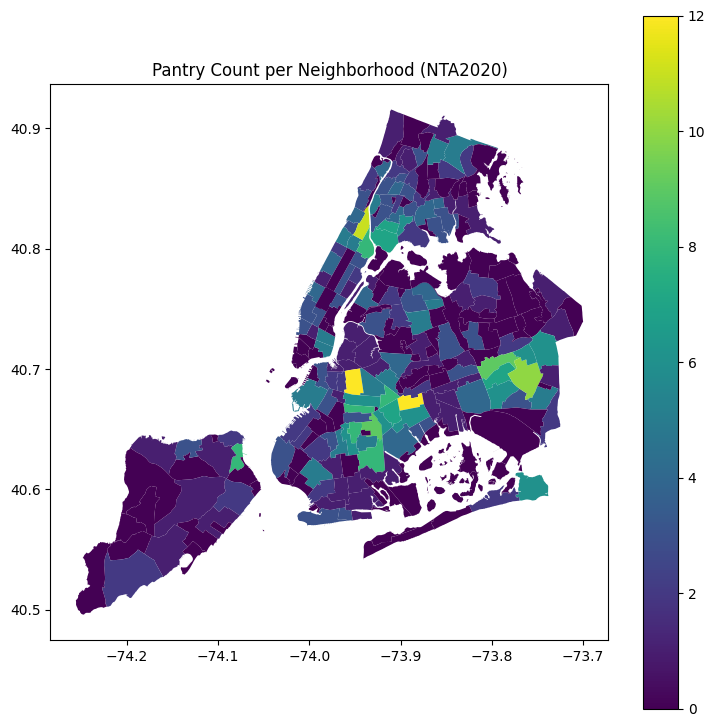

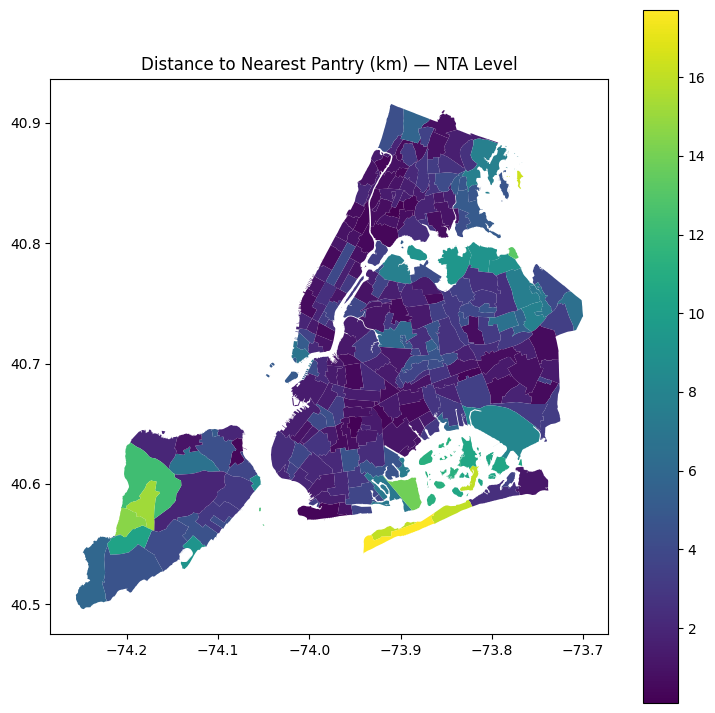

In [23]:

# ---- Quick choropleths ----

ax = nta_enriched.plot(
    column='pantry_count',
    legend=True,
    figsize=(9, 9),
    edgecolor="none"
)
plt.title("Pantry Count per Neighborhood (NTA2020)")
plt.show()

ax = nta_enriched.plot(
    column='dist_km',
    legend=True,
    figsize=(9, 9),
    edgecolor="none"
)
plt.title("Distance to Nearest Pantry (km) — NTA Level")
plt.show()
